In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Heart Disease Prediction

## Summary

This project is was designed around the usage of common health observations associated with heart disease. We will initially explore the data before using a commonly available machine learning model called **K Nearest Neighbor** to predict patients with high risk of heart disease. 

## Data Set

This is a publicly available dataset found on kaggle [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

### Data Set Legend

**Age** - The age of the individual in years.

**Sex** - The sex of the individual. Male or Female.

**ChestPainType** - Pain defined by the source. "ASY" typically refers to angina (chest pain caused by reduced blood flow to the heart). "NAP" is for pain caused by not directly linked to activity, such as acid reflux or muscle strain.

**RestingBP** - The resting blood pressure of the individual.

**Cholesterol** - The serum measurement. Commonly referred to as the "total cholesterol". 

**fastingBS** - Blood sugar measured in mg/dL. Fasting blood sugar must be measured after at least eigh hours of fasting.

**RestingECG** - ECG measurements when the individual is at rest, typically in a comfortable lying down position.

**MaxHR** - The maximum heart rate measured by an individual under strenuous activity such as interval exercise.

**ExerciseAngina** - Chest pain that occurs when the heart muscle is strained during exercise.

**Oldpeak** - A value in ECG that measures the depression in the ST segment caused by exercise relative to rest.

**ST_Slope** - The slope of the peak exercise ST segment during an ECG.

**HeartDisease** - If the individual has heart disease. Either "yes" (1) or "no" (0). This is the target variable for our machine learning.

In [3]:
df = pd.read_csv("heart_disease_prediction.csv")


After reading in the data we can see that the column names are not normalized. This should be done for easy use in the future as we work with different features. We use column string replacements with RegEx to normalize with python standards for underscores between words.

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.columns = (
    df.columns
    .str.replace(r'(?<=[a-z])(?=[A-Z])', '_', regex=True)  # Add underscore between lowercase and uppercase letters
    .str.replace(r'(?<=[A-Z])(?=[A-Z][a-z])', '_', regex=True)  # Add underscore between consecutive capitals followed by lowercase
    .str.lower()  # Convert to lowercase
)

Now that the columns are updated, we can begin to view the data. Let's find out some basic statistics about each feature and see what data engineering is required for the data set. 

### Initial View

The data reflects marginally skewed in some features such as Age, Resting BP, and Max HR. Some of the features are encoded so the mean and median are less helpful. We can see that a skew is apparent with Fasting BS with the quartile ranges reflecting over 75% of values are 0. We can either assume that the data was marked zero to fill nulls previously or fasting blood sugar tests were not sampled equally.

We have:
* 5 object types (*sex*, *chest_pain_type*, *resting_ecg*, *exercise_angina*, and *st_slope*)
* 6 whole number (integer) types (*age*, *resting_bp*, *cholesterol*, *fasting_bs*, *max_hr*, *heart_disease*)
* 1 float (*old_peak*)



**Concerns about Data**

We see that the *serum cholesterol* feature has a minimum of 0, which would be an extremely unheard of medical case. We can infer this means that we have records where cholesterol was improperly measured or nulls were previously filled with zeroes. When filtering the data out, we see that approximately 19% of the total sample is missing a cholesterol value. This is too large of a pool of records to simply drop. We will need to investigate the values and potentially compute the median values to insert them.




In [14]:
df.dtypes

age                  int64
sex                 object
chest_pain_type     object
resting_bp           int64
cholesterol          int64
fasting_bs           int64
resting_ecg         object
max_hr               int64
exercise_angina     object
oldpeak            float64
st_slope            object
heart_disease        int64
dtype: object

In [6]:
df.describe()

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,heart_disease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
df.loc[df['cholesterol'] == 0]

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


### Object Data 

Are the categorical features equal or are they skewed?


In [8]:
obj_dtypes = df.select_dtypes('object')

In [9]:
obj_dtypes

,sex,chest_pain_type,resting_ecg,exercise_angina,st_slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


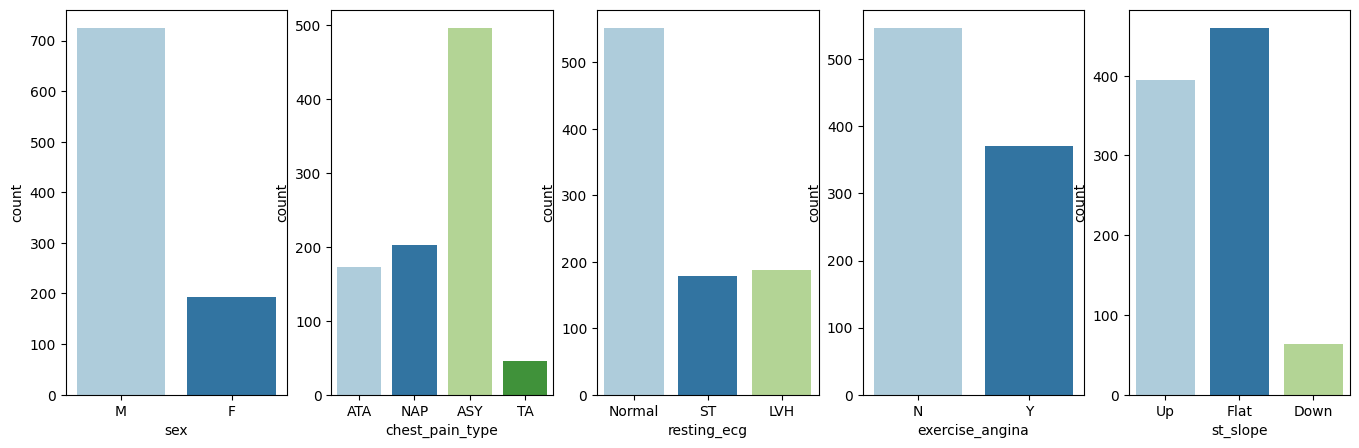

In [39]:
plt.figure(constrained_layout=False, figsize=(20, 5))

# 2 rows, 3 columns per

# 1st row
plt.subplot(1, 6, 1)
sns.countplot(obj_dtypes,x='sex',hue='sex',palette='Paired')

plt.subplot(1, 6, 2)
sns.countplot(obj_dtypes,x='chest_pain_type',hue='chest_pain_type',palette='Paired')

# 2nd row
plt.subplot(1, 6, 3)
sns.countplot(obj_dtypes,x='resting_ecg',hue='resting_ecg',palette='Paired')

plt.subplot(1, 6, 4)
sns.countplot(obj_dtypes,x='exercise_angina',hue='exercise_angina',palette='Paired')

plt.subplot(1, 6, 5)
sns.countplot(obj_dtypes,x='st_slope',hue='st_slope',palette='Paired')

plt.show()




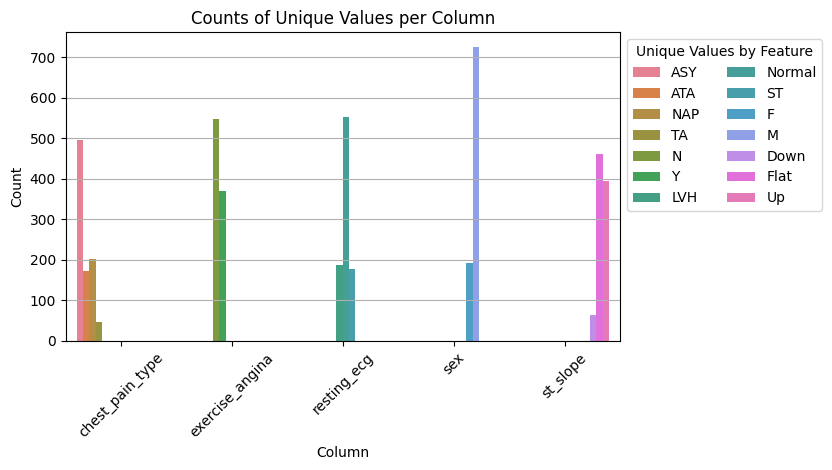

In [10]:

# Reshape the DataFrame to a long format
df_melted = obj_dtypes.melt(var_name='Column', value_name='Value')

# Count occurrences of each unique value per column
value_counts = df_melted.groupby(['Column', 'Value']).size().reset_index(name='Count')


# Create a custom color palette for better distinction
# palette = sns.color_palette('husl', n_colors=len(value_counts['Value'].unique()))

# Create the bar plot

sns.barplot(data=value_counts, x='Column', y='Count', hue='Value')



# Customize the plot
plt.title('Counts of Unique Values per Column')
plt.ylabel('Count')
plt.xlabel('Column')
plt.yticks(range(0,800, 100))
plt.grid(axis='y')
plt.legend(title='Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Unique Values by Feature", loc="upper left", bbox_to_anchor=(1,1), ncols=2)
# Show the plot
plt.show()

In [11]:
grouped_by_hd = obj_dtypes.copy()
grouped_by_hd['heart_disease'] = df['heart_disease']

In [12]:
grouped_by_hd = grouped_by_hd.groupby('heart_disease').value_counts().to_json()

In [13]:
grouped_by_hd

'{"(0, \'M\', \'ATA\', \'Normal\', \'N\', \'Up\')":63,"(0, \'M\', \'NAP\', \'Normal\', \'N\', \'Up\')":43,"(0, \'F\', \'ATA\', \'Normal\', \'N\', \'Up\')":34,"(0, \'M\', \'ASY\', \'Normal\', \'N\', \'Up\')":28,"(0, \'F\', \'NAP\', \'Normal\', \'N\', \'Up\')":18,"(0, \'M\', \'ATA\', \'ST\', \'N\', \'Up\')":11,"(0, \'M\', \'ASY\', \'ST\', \'N\', \'Up\')":10,"(0, \'M\', \'NAP\', \'LVH\', \'N\', \'Up\')":10,"(0, \'F\', \'ATA\', \'ST\', \'N\', \'Up\')":9,"(0, \'F\', \'NAP\', \'LVH\', \'N\', \'Up\')":9,"(0, \'F\', \'ASY\', \'Normal\', \'N\', \'Up\')":8,"(0, \'F\', \'NAP\', \'Normal\', \'N\', \'Flat\')":8,"(0, \'M\', \'ATA\', \'LVH\', \'N\', \'Up\')":8,"(0, \'M\', \'ASY\', \'LVH\', \'N\', \'Up\')":7,"(0, \'M\', \'NAP\', \'ST\', \'N\', \'Up\')":6,"(0, \'M\', \'ASY\', \'Normal\', \'Y\', \'Flat\')":5,"(0, \'M\', \'NAP\', \'LVH\', \'N\', \'Flat\')":5,"(0, \'M\', \'NAP\', \'Normal\', \'Y\', \'Up\')":5,"(0, \'F\', \'ASY\', \'LVH\', \'N\', \'Flat\')":4,"(0, \'F\', \'ASY\', \'LVH\', \'N\', \'Up\')":4